<a href="https://colab.research.google.com/github/hannape/IBAC-Biodiv/blob/master/project2_moje_zmiany.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Funkcje Pomocnicze do Zadania

Aby wszystkie funkcje zadziałały, notebook powinien być uruchamiany z następującym ułożeniem katalogów:

```
|- helpers.ipynb
|- sampleSubmission.csv
|- train
 |- {unzipped train files and labels}
|- test
 |- {unzipped test files}
```

Należy odkomentować u siebie linijki zapisujące pliki.

In [0]:
import os

import librosa
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
import wave
import contextlib
import math

In [240]:
from google.colab import drive
drive.mount('/content/drive')
from __future__ import print_function

Mounted at /content/drive


# Wczytywanie Danych

Poniższe funkcje są przykładowymi funkcjami wczytującymi dane. Możliwe, że będą potrzebne modyfikacje reprezentacji i bardziej skomplikowana funkcja tworząca zbiór treningowy. Wczytywanie danych nie jest zaimplementowane optymalnie - między innymi kod wczytuje wielokrotnie ten sam plik. Dla bardziej złożonych reprezentacji możliwe, że trzeba będzie przepisać te funkcje.

In [0]:
def load_mel(file_name, start=0, stop=None, n_mels=128):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    samples, sample_rate = librosa.core.load(file_name, sr = None)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate,
                                                 n_mels = n_mels, fmin = 4000, fmax = 9500)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    #print(np.shape(spectrogram))
    return spectrogram


def load_spec(file_name, start=0, stop=None):
    '''Wczytuje standardowy spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
    
    Returns:
        ndarray: Spektrogram.
    '''
    sample_rate, samples = wavfile.read(file_name)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    _, _, spectrogram = signal.spectrogram(samples, sample_rate)
    return spectrogram


def load_test(load_repr=load_mel):
    '''Wczytuje dane testowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        ndarray: Tablica z danymi testowymi.
    '''
    with open('drive/My Drive/top2/sampleSubmission.csv', 'r') as file:
        lines = file.read().split()[1:]
        sample_ids = [line.split(',')[0] for line in lines]
        samples = np.array([s.split('/') for s in sample_ids])
    
    X_test = []
    rec_files = sorted([file_name for file_name in os.listdir('drive/My Drive/test') 
                        if file_name.endswith('.wav')], key=lambda x: int(x.split('.')[0][3:]))
    for file_name in rec_files:
        recording_id = file_name.split('.')[0][3:]
        time_markers = samples[samples[:, 0] == recording_id, 1].astype(np.int)
        for t in time_markers:
            representation = load_repr(os.path.join('drive/My Drive/test', file_name), start = t, stop = t + 1)
            X_test.append(representation)
    return np.array(X_test)


def read_labels():
    '''Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    '''
    labels = []
    with open(os.path.join('drive/My Drive/train', 'labels.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[1:]:
            if len(line) > 1:
                rec, start, stop = line.split(',')
                rec, start, stop = int(rec[3:]), float(start), float(stop)
                labels.append([rec, start, stop])
    return np.array(labels)


def check_voices(second, labels, tol=0.):
    '''Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
    '''
    return (labels[1] >= second and labels[1] < second + 1 - tol) or \
           (labels[2] < second + 1 and labels[2] > second + tol) or \
           (labels[1] < second and labels[2] > second + 1)


def map_seconds_to_y(labels):
    '''Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    '''
    y = [0] * 10
    y_restrictive = [0] * 10
    for s in range(10):
        for l in labels:
            if check_voices(s, l):
                y[s] = 1
            if check_voices(s, l, 0.02):
                y_restrictive[s] = 1
        if y[s] != y_restrictive[s]:
            y[s] = -1
    return y


def load_train(load_repr=load_mel):
    '''Wczytuje dane treningowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    labels = read_labels()
    X_train, y_train = [], []
    rec_files = [file_name for file_name in os.listdir('drive/My Drive/train') if file_name.endswith('.wav')]
    for file_name in rec_files:
        recording_id = int(file_name.split('.')[0][3:])
        recording_labels = labels[labels[:, 0] == recording_id]
        y_binary = map_seconds_to_y(recording_labels)
        for i, y in enumerate(y_binary):
            if y != -1:
                try:
                    representation = load_repr(os.path.join('drive/My Drive/train', file_name), start = i, stop = i + 1)
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
    return np.array(X_train), np.array(y_train)

In [0]:
from google.colab import drive
drive.mount('/content/drive')
from __future__ import print_function
###########################Dodatkowe, do innego wczytywania nagrań, i innego zapisu predykcji. Do stworzenia testowego 
  
path_test1618 = 'drive/My Drive/testowe_1618/'

def my_load_mel(samples, start=0, stop=None ):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    sample_rate = 44100
    n_mels=128
    #samples, sample_rate = librosa.core.load(file_name, sr = None)
   
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    #if np.shape(samples[0])<sample_rate:
    if(np.shape(samples)[0] < sample_rate):
      diff = sample_rate - np.shape(samples)[0]
      samples = np.pad(samples, (0,diff), 'constant', constant_values=(0))
      print((samples))
      print(np.shape(samples))
     
      
      
      
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate,
                                                   n_mels = n_mels, fmin = 4000, fmax = 9500)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    #print(np.shape(spectrogram))
    return spectrogram


def my_check_voices(second, labels, tol=0.):
    '''Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
    
    
    if(float(labels[0]) >= second and float(labels[0]) < second + 1 - tol) or \
           (float(labels[1]) < second + 1 and float(labels[1]) > second + tol) or \
           (float(labels[0]) < second and float(labels[1]) > second + 1):
            print("def my_check_voices") 
            print(second)
     
    calls_to_cut = ['t', 't?', 't ','t  ', 'g', 'czapla', 'gh', 'g cz', 'puszczyk','gaski','g?','mewa?','zwierzak?','high freq','g niskie','??? mysz']
    if ((float(labels[0]) >= second and float(labels[0]) < second + 1 - tol) or \
           (float(labels[1]) < second + 1 and float(labels[1]) > second + tol) or \
           (float(labels[0]) < second and float(labels[1]) > second + 1)) and (labels[2] in calls_to_cut): 
      #y_read[~y_read['bird'].isin(calls_to_cut)]
      print(second,labels[2])''' 
    return (float(labels[0]) >= second and float(labels[0]) < second + 1 - tol) or \
           (float(labels[1]) < second + 1 and float(labels[1]) > second + tol) or \
           (float(labels[0]) < second and float(labels[1]) > second + 1) and (labels[2] in calls_to_cut)


def my_read_labels(label_name):
    '''Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    '''
    labels = []
    with open(os.path.join(path_test1618, label_name + '.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[0:]:
            if len(line) > 1:
                start, stop, spec = line.split('\t')
                print(start)
                start, stop, spec = float(start), float(stop), str(spec),
                labels.append([start, stop, spec])
    return np.array(labels)

  
def my_map_seconds_to_y(labels, recording_duration):
    '''Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    '''
    calls_to_cut = ['t', 't?', 't ','t  ', 'g', 'czapla', 'gh', 'g cz', 'puszczyk','gaski','g?','mewa?','zwierzak?','high freq','g niskie','??? mysz']

    y = [0] * recording_duration
    y_restrictive = [0] * recording_duration
    for s in range(recording_duration):
        for l in labels:
            if my_check_voices(s, l):
                y[s] = 1
                if l[2] in calls_to_cut:
                  y[s] = 0
                  print("Labele1: " + l[2]) 
            if my_check_voices(s, l, 0.02):
                y_restrictive[s] = 1
                if l[2] in calls_to_cut:
                  y_restrictive[s] = 0
                  print("Labele2: " + l[2]) 
        if y[s] != y_restrictive[s]:
            y[s] = -1          
        
    print("Labele dla nagrania: " + str(y))        
    return y
  
  
def my_load_test(load_repr=my_load_mel):
    '''Wczytuje dane testowe, moje, długie nagrania.

    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.

    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    
    
    X_train, y_train = [], []
    samples, sample_rate2 = [], []
    rec_files = [file_name for file_name in os.listdir(path_test1618) if file_name.endswith('.wav')]
    print(rec_files)
    #rec_files3 = rec_files[0:6] 
    #print(rec_files3)
    for file_name in  rec_files: # range(0,3):#
        #file_name = rec_files[]
        recording_id = (file_name.split('.')[0])
        print("------------Analiza nagrania: " + file_name + "-----------")
        fname = path_test1618 + file_name
        with contextlib.closing(wave.open(fname,'r')) as f:
            frames = f.getnframes()
            rate = f.getframerate()
            duration = frames / float(rate)
            recording_duration = math.ceil(duration)
            print("Czas trwania - w sekundach: " + str(recording_duration))
        
        #recording_labels = labels[labels[:, 0] == recording_id]
        recording_labels = my_read_labels(recording_id)
        y_binary = my_map_seconds_to_y(recording_labels, recording_duration)
        print("+++++++++++++++")
        print(fname)
        print("+++++++++++++++")
        
        samples, sample_rate2 = librosa.core.load(fname, sr = None)
        print(np.shape(samples))
        for i, y in enumerate(y_binary):
            if y != -1:
                try:
                    representation = load_repr(samples, start = i, stop = i + 1)
                    if (i%500==0):
                      print(i)
                      end_time = datetime.datetime.now()
                      print(end_time - start_time)
                      print(np.shape(X_train),np.shape(y_train))
                      start_time == end_time
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
        #print(np.shape(X_train),np.shape(y_train))           
    return np.array(X_train), np.array(y_train)

In [0]:
####### Przygotowanie zbalansowanego treningu - 

In [0]:
import datetime
start_time = datetime.datetime.now()
X_test, y_test = my_load_test()

In [0]:
print(np.shape(X_test))
np.savez(path_test1618 + "testowe_1618", X_test=X_test,y_test=y_test)
Xtest =  np.load(path_test1618 + "testowe_1618.npz")
print(sum((Xtest["y_test"])==0))

In [0]:
with open('drive/My Drive/top2/sampleSubmission.csv', 'r') as file:
    lines = file.read().split()[1:]
    sample_ids = [line.split(',')[0] for line in lines]
    samples = np.array([s.split('/') for s in sample_ids])
    print(lines, sample_ids,samples)

In [33]:
X, y = load_train()

print(X.shape)
print(y.shape)

(3589, 128, 87)
(3589,)


In [0]:

#X_test = load_test()

In [34]:
#X_test, y_test = my_load_train()

print(X_test.shape)
print(y_test.shape)

(35960, 128, 87)
(35960,)


# Model i Trenowanie

Poniższy przykład używa poprawnych metryk i zapisuje parametry modelu.

In [0]:
# Dzielenie zbioru danych na treningowy i walidacyjny
split_point = int(len(X) * 0.8)

X_train = torch.Tensor(X[:split_point])
y_train = torch.LongTensor(y[:split_point])

X_valid = torch.Tensor(X[split_point:])
y_valid = torch.LongTensor(y[split_point:])

batch_size = 64

dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_data_loader = DataLoader(valid_dataset, batch_size = batch_size)

In [0]:
from torch import nn

# kopia architektury resnet z biblioteki pytorch (licencja cc)
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2, zero_init_residual=False, # zmiana na 2 klasy
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)  # <<< konwersja na 1 kanał
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x

clf = ResNet(BasicBlock, [2, 2, 2, 2]).cuda()

In [37]:

import calendar;
import time;
ts = calendar.timegm(time.gmtime())

for run in range(10):
    losses, scores = [], []
    epoch = 0
    clf = ResNet(BasicBlock, [2, 2, 2, 2]).cuda()

    # Ustawienie kosztu i optimizera
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(clf.parameters())

    # Pętla uczenia
    best_preds, best_score = None, 0.
    batches = X_train.shape[0]//64
    torch.set_num_threads(55)

    for epoch in range(15):
        running_loss = 0
        clf.train()
        batch = 0
        for X, y in data_loader:
            X = X[:,None,:,:]
            batch = batch+1

            optimizer.zero_grad()

            outputs = clf(X.cuda())
            loss = criterion(outputs, y.cuda())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        losses.append(running_loss)

        clf.eval()
        preds = []
        for X, _ in valid_data_loader:
            X = X[:,None,:,:]
            out = clf(X.cuda())
            preds.append(torch.softmax(out, dim = 1)[:, 1].cpu().detach().numpy())
        preds = np.concatenate(preds, axis = 0)

        # Metryką testującą jest ROC AUC
        score = roc_auc_score(y_valid.numpy(), preds)
        scores.append(score)
        #print('Epoch:', epoch, 'Batch', batch+1, '/', batches, 'Score:', score, 'Loss', running_loss)
        if score > best_score:
            best_score = score
            best_preds = preds
            #np.save('tmp_preds', best_preds)

            # Model dający najlepszy wynik powinien być zapisany
            torch.save(clf.state_dict(), 'tmp_model.pt')
            
    print(run, "score", best_score)
    if best_score > 0.945:
        print('Saving')
        state = torch.load('tmp_model.pt')
        t = "drive/My Drive/models/top2/" + str(ts)
        os.makedirs(t, exist_ok=True)
        torch.save(state, t + '/run_' + str(run) + '_' + str(best_score) + '.pt')

0 score 0.9485496411483253
Saving
1 score 0.9300687799043061


KeyboardInterrupt: ignored

Best score 0.9423594497607656


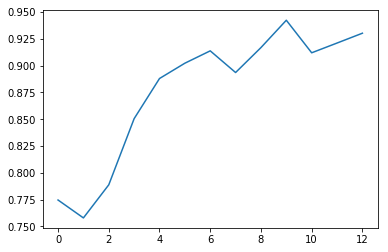

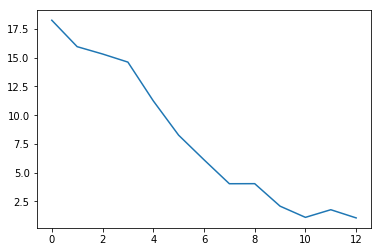

In [38]:
# Rysowanie lossu i AUC

import matplotlib.pyplot as plt

%matplotlib inline

print('Best score', best_score)

plt.plot(scores)
plt.show()

plt.plot(losses)
plt.show()

In [47]:
#clf.load_state_dict(torch.load('tmp_model.pt'))

#clf.load_state_dict(torch.load('./models/1558383876/run_5_0.9504516129032259.pt'))
#clf.load_state_dict(torch.load('drive/My Drive/models/top2/1570200649/run_0_0.9485496411483253.pt'))

clf.load_state_dict(torch.load('drive/My Drive/top2/weights.pt'))


<All keys matched successfully>

# Zapis Predykcji

In [0]:
#@title
def save_predictions(preds):
    '''Zapisuje predykcje do pliku zgodnego z formatem odpowiedzi.
    
    Args:
        preds (list): Lista predykcji (prawdopodobieństw).
    '''
    with open('sampleSubmission.csv', 'r') as file:
        submission_text = file.read().split()
        header = submission_text[0]
        lines = submission_text[1:]

    output_lines = [header]
    for pred, line in zip(preds, lines):
        output_lines.append("{},{}".format(line.split(',')[0], pred))
    
    with open('mySubmission.csv', 'w') as file:
        file.write('\n'.join(output_lines) + '\n')

In [48]:
# Wczytanie najlepszego modelu
# clf.load_state_dict('tmp_model.pt')

# Tworzenie data loadera testowego
X_test_tensor = torch.Tensor(X_test)

test_dataset = TensorDataset(X_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size)

# Ewaluacja modelu na danych testowych
clf.eval()
preds = []
for X in test_data_loader:
    X = X[0]
    X = X[:,None,:,:]
    out = clf(X.cuda())
    preds.append(torch.softmax(out, dim = 1)[:, 1].cpu().detach().numpy())
preds = np.concatenate(preds, axis = 0)

# Zapisanie predykcji do poprawnego formatu
#save_predictions(preds)
print('Done')

Done


In [49]:
print(preds)
print(np.shape(preds))

[2.1411208e-05 3.0602310e-05 1.1669370e-06 ... 9.3661540e-05 1.2766370e-05
 5.5319097e-06]
(35960,)


In [50]:
score = roc_auc_score(y_test, preds)
print(score)

0.9110486154170139


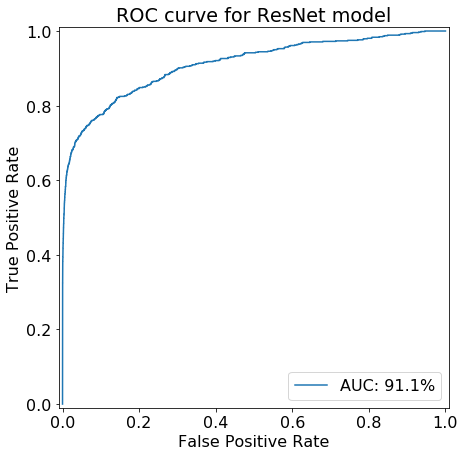

In [62]:
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import os
import matplotlib
from scipy import interp

font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(7,7))
score_per = score*100
fpr, tpr, thresholds = roc_curve(y_test, preds)
plt.plot(fpr,tpr)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.title("ROC curve for ResNet model")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(["AUC: %.1f%%" % score_per],loc = 'lower right')